In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xarray as xr
import pandas as pd
import seaborn as sns

import itertools
import datetime
import time
import sys  
import re

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.deep_learning import tf_metrics as metrics

from soundings.preprocessing import dataloader as dl

from soundings.plotting import radiosonde_plotting, results
from soundings.utils import radiosonde_products, radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
processed_vol = '/mnt/data1/stock/mlsoundings/processed/'
PLOT_CMAP = 'RdYlBu_r'

gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    # tf.config.experimental.set_visible_devices(device, 'GPU')
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')

Fri Oct 23 21:16:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:3D:00.0 Off |                  Off |
| 33%   31C    P8    13W / 260W |     16MiB / 24212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----

# Evaluation Functions

In [3]:
def parition(rap=None, raob=None, goes=None, rtma=None, 
             percentages=(0.8,0.2), shuffle=False):
    
    trainFraction, testFraction = percentages
    n = raob.shape[0]
    nTrain = round(trainFraction * n)
    nTest = round(testFraction * n)
    rowIndices = np.arange(n)
    if shuffle:
        np.random.shuffle(rowIndices)
        
    RAPtrain  = None
    RAPtest   = None
    RAOBtrain = None
    RAOBtest  = None
    GOEStrain = None
    GOEStest  = None
    RTMAtrain = None
    RTMAtest  = None
    
    if rap is not None:
        RAPtrain = rap[rowIndices[:nTrain], :]
        RAPtest  = rap[rowIndices[nTrain:nTrain+nTest], :]
        
    if raob is not None:
        RAOBtrain = raob[rowIndices[:nTrain], :]
        RAOBtest  = raob[rowIndices[nTrain:nTrain+nTest], :]
        
    if goes is not None:
        GOEStrain = goes[rowIndices[:nTrain], :]
        GOEStest  = goes[rowIndices[nTrain:nTrain+nTest], :]
        
    if rtma is not None:
        RTMAtrain = rtma[rowIndices[:nTrain], :]
        RTMAtest  = rtma[rowIndices[nTrain:nTrain+nTest], :]
    
    return (RAPtrain, RAOBtrain, GOEStrain, RTMAtrain,
            RAPtest, RAOBtest, GOEStest, RTMAtest)

# Data Loader

In [4]:
raob, rap, goes, rtma, sonde_files = dl.load_preprocessed_samples(processed_vol, shuffle=True)

print(raob.shape, rap.shape, goes.shape, rtma.shape)

total of 1283 samples!


FloatProgress(value=0.0, max=1283.0)

time: 33.411, avg: 0.026 seconds
(1283, 256, 4) (1283, 256, 4) (1283, 3, 3, 8) (1283, 3, 3, 3)


In [4]:
f = '/mnt/data1/stock/mlsoundings/preprocessed.npz'
# np.savez(f, raob=raob, rap=rap,
#          goes=goes, rtma=rtma, sonde_files=sonde_files)

container = np.load(f)

print(container.files)

raob = container['raob']
rap = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files']
diff = raob[:,:,dl.TEMPERATURE] - rap[:,:,dl.TEMPERATURE]

threshold = 20
inds = np.unique(np.where(abs(diff) >= threshold)[0])

raob = np.delete(raob, inds, 0)
rap  = np.delete(rap, inds, 0)
goes = np.delete(goes, inds, 0)
rtma = np.delete(rtma, inds, 0)
sonde_files = np.delete(sonde_files, inds, 0)

print(raob.shape, rap.shape, goes.shape, rtma.shape)

['raob', 'rap', 'goes', 'rtma', 'sonde_files']
(35171, 256, 4) (35171, 256, 4) (35171, 3, 3, 8) (35171, 3, 3, 3)


In [10]:
ml.rmse(rap[:,:,dl.DEWPOINT], raob[:,:,dl.DEWPOINT]), ml.rmse(rap[:,:,dl.TEMPERATURE], raob[:,:,dl.TEMPERATURE])

(5.67576065770167, 1.1314062070416473)

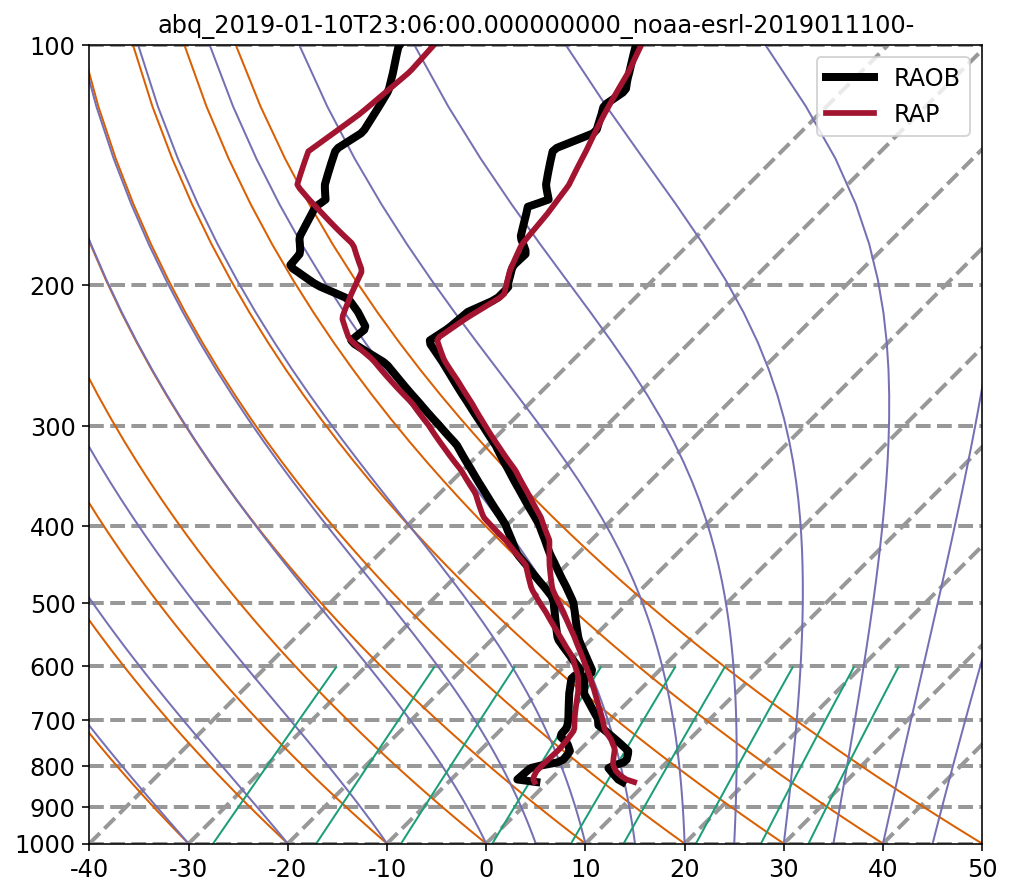

In [5]:
index = 4
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = rap[index,:,dl.PRESSURE]

sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = raob[index,:,dl.TEMPERATURE]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = rap[index,:,dl.TEMPERATURE]

sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = raob[index,:,dl.DEWPOINT]
sounding[radiosonde_utils.NWP_DEWPOINT_COLUMN_KEY] = rap[index,:,dl.DEWPOINT]

title = sonde_files[index].split('/')[-1][:-4]
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title);
                                         # file_name=f"/home/stock/research/media/{title}-rapvraob.png");

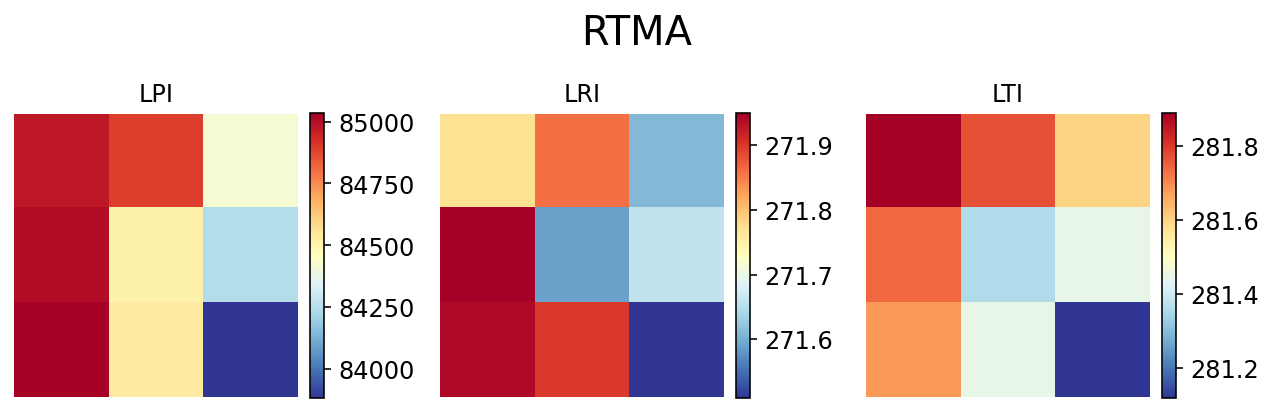

In [6]:
rtma_type = np.array(['LPI', 'LRI', 'LTI'])

fig, axs = plt.subplots(1, 3, figsize=(9,3))
[axi.set_axis_off() for axi in axs.ravel()]
for i in range(3):
    c = axs[i].imshow(rtma[index,:,:,i], cmap=PLOT_CMAP)
    fig.colorbar(c, ax=axs[i], fraction=0.046, pad=0.04)
    axs[i].set_title(f'{str(rtma_type[i])}')
fig.suptitle('RTMA', fontsize=20)
fig.tight_layout()

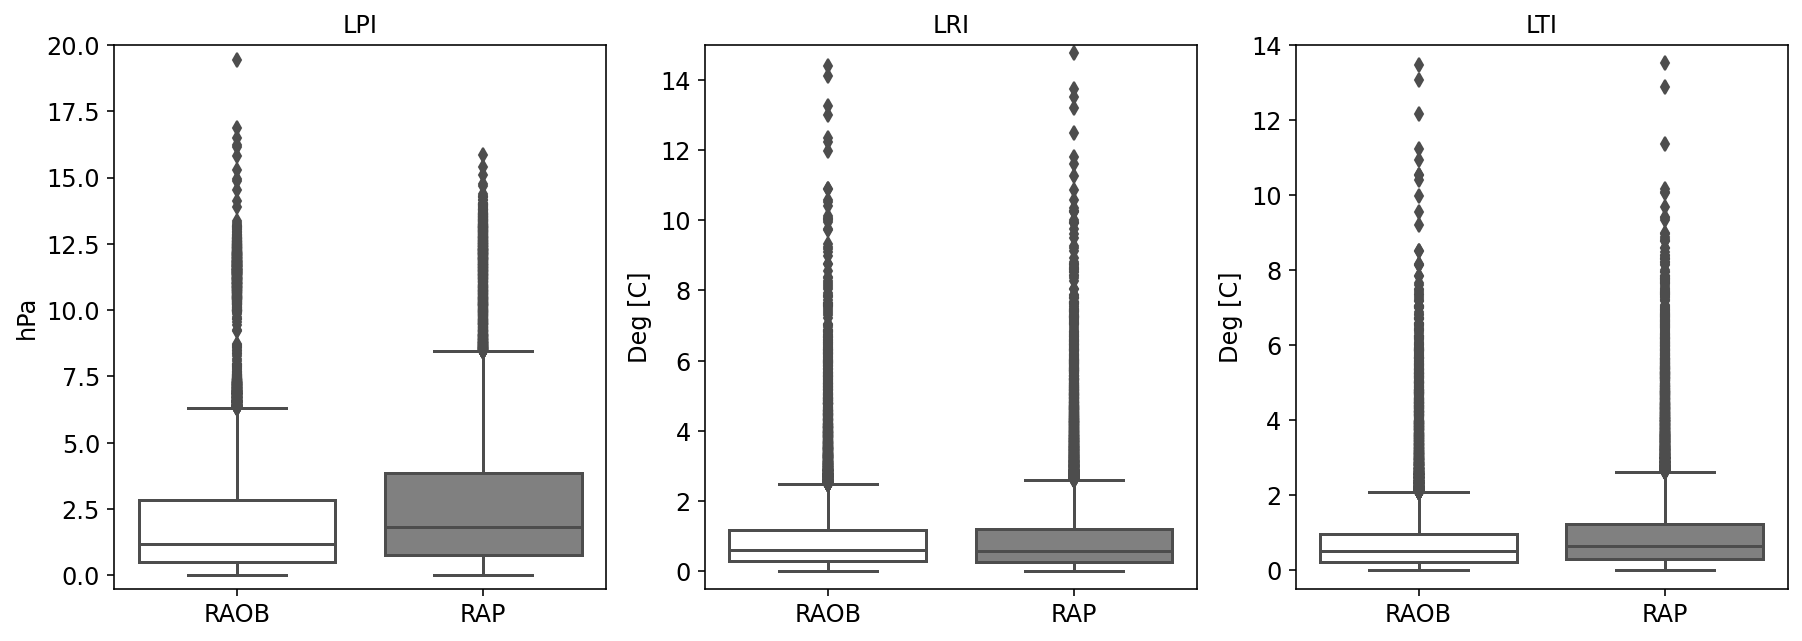

In [7]:
p_raob_diff = np.abs(rtma[:, 1, 1, 0] / 100. - raob[:, 0, dl.PRESSURE])
r_raob_diff = np.abs(rtma[:, 1, 1, 1] - 273.15 - raob[:, 0, dl.DEWPOINT])
t_raob_diff = np.abs(rtma[:, 1, 1, 2] - 273.15 - raob[:, 0, dl.TEMPERATURE])

p_rap_diff = np.abs(rtma[:, 1, 1, 0] / 100. - rap[:, 0, dl.PRESSURE])
r_rap_diff = np.abs(rtma[:, 1, 1, 1] - 273.15 - rap[:, 0, dl.DEWPOINT])
t_rap_diff = np.abs(rtma[:, 1, 1, 2] - 273.15 - rap[:, 0, dl.TEMPERATURE])

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axs = axs.ravel()
palette = ['white', 'gray']

sns.boxplot(data=[p_raob_diff, p_rap_diff], palette=palette, ax=axs[0])
axs[0].set_ylim(-0.5, 20); axs[0].set_title('LPI')
axs[0].set_xticklabels(['RAOB', 'RAP'])
axs[0].set_ylabel('hPa')

sns.boxplot(data=[r_raob_diff, r_rap_diff], palette=palette, ax=axs[1])
axs[1].set_ylim(-0.5, 15); axs[1].set_title('LRI')
axs[1].set_xticklabels(['RAOB', 'RAP'])
axs[1].set_ylabel('Deg [C]')

sns.boxplot(data=[t_raob_diff, t_rap_diff], palette=palette, ax=axs[2])
axs[2].set_ylim(-0.5, 14); axs[2].set_title('LTI')
axs[2].set_xticklabels(['RAOB', 'RAP'])
axs[2].set_ylabel('Deg [C]');

plt.savefig('/home/stock/research/media/rtma-vs-rap-raob.png', dpi=300)

# RAP + RTMA

### Temperature

In [9]:
RAPtrain, RAOBtrain, _, RTMAtrain, RAPtest, RAOBtest, _, RTMAtest = parition(rap=rap, raob=raob, rtma=rtma, 
                                                                             shuffle=True)

input_dims = [dl.PRESSURE, dl.TEMPERATURE]

RAPtrain = RAPtrain[:, :, input_dims]
RAOBtrain = RAOBtrain[:, :, dl.TEMPERATURE]

RAPtest = RAPtest[:, :, input_dims]
RAOBtest = RAOBtest[:, :, dl.TEMPERATURE]

RAPtrain.shape, RAOBtrain.shape, RTMAtrain.shape, RAPtest.shape, RAOBtest.shape, RTMAtest.shape

((28137, 256, 2),
 (28137, 256),
 (28137, 3, 3, 3),
 (7034, 256, 2),
 (7034, 256),
 (7034, 3, 3, 3))

## Basic Model

In [30]:
im_hiddens = []
n_units_in_conv = [32, 32, 32]

nnet = nn.MultiNeuralNetwork(RTMAtrain.shape[1:], RAPtrain.shape[1:],
                             goes_hiddens, n_units_in_conv, [(10, 1)]*len(n_units_in_conv), 
                             RAOBtrain.shape[1], im_activation='tanh', rap_activation='tanh', seed=1234)

nnet.train(RTMAtrain, RAPtrain, RAOBtrain, 100, 64, method='adam',
                     validation=(RTMAtest, RAPtest, RAOBtest), verbose=True, learning_rate=0.0001)

epoch: 0, rmse 2.47160, val_rmse 1.55007
epoch: 20, rmse 1.07043, val_rmse 1.05419
epoch: 40, rmse 1.05893, val_rmse 1.04321


MultiNeuralNetwork(256)
  Final objective value is 0.02917 in 78.3485 seconds.

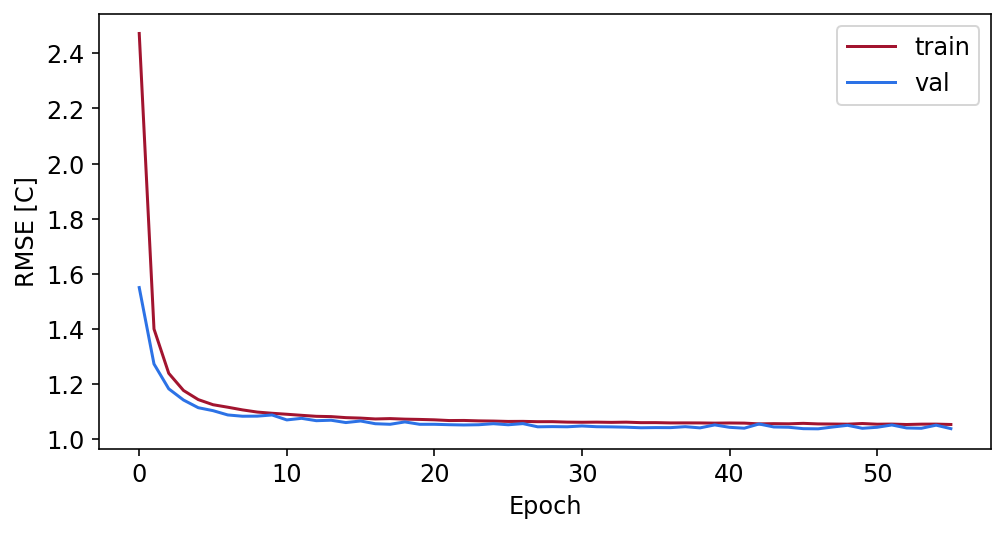

In [31]:
results.plot_loss(nnet)

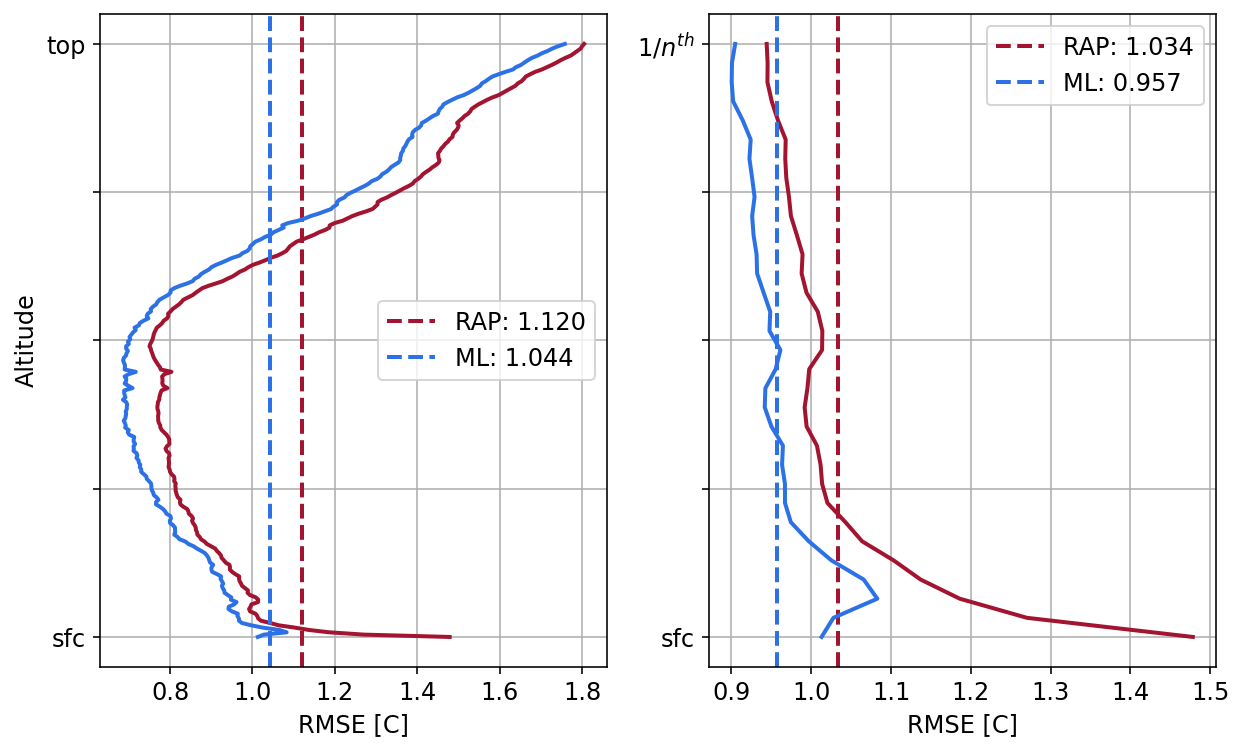

In [32]:
results.plot_altitude_rmse_verticle(nnet, {'im': RTMAtest, 'rap': RAPtest},
                                    RAOBtest, RAPtest[:,:,dl.TEMPERATURE])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

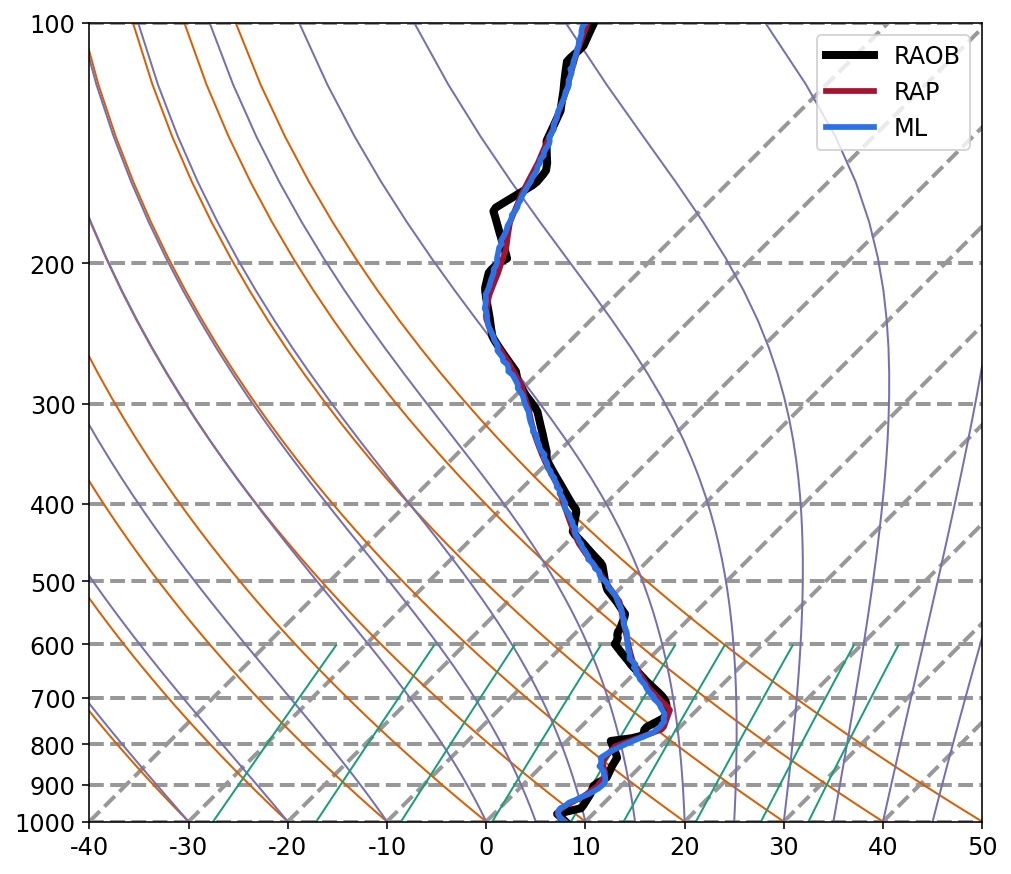

In [54]:
i = 115
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use({'im':RTMAtest[i:i+1],'rap':RAPtest[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## Model Search

In [56]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

im_hiddens_list = [[]] + [[nu] * nl for nu in [8, 16, 32] for nl in range(1, 3)]
n_units_in_conv_layers = [[nu] * nl for nu in [32, 128] for nl in range(2, 4)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

product = list(itertools.product(im_hiddens_list, n_units_in_conv_layers))

print(f'{len(product)} experiments.')
f = FloatProgress(min=0, max=len(product))
display(f)

for im_hiddens, n_units_in_conv in product:
    nnet = nn.MultiNeuralNetwork(RTMAtrain.shape[1:], RAPtrain.shape[1:],
                                 im_hiddens, n_units_in_conv, [(10, 1)]*len(n_units_in_conv), 
                                 RAOBtrain.shape[1], im_activation='tanh', rap_activation='tanh', 
                                 seed=1234)
    nnet.train(RTMAtrain, RAPtrain, RAOBtrain, 100, 64, method='adam',
               validation=(RTMAtest, RAPtest, RAOBtest), verbose=False, learning_rate=0.0001)

    Y = nnet.use({'im': RTMAtrain, 'rap': RAPtrain})
    train_percentage.append(ml.rmse(RAOBtrain, Y))

    Y = nnet.use({'im': RTMAtest, 'rap': RAPtest})
    temp = ml.rmse(RAOBtest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

28 experiments.


FloatProgress(value=0.0, max=28.0)

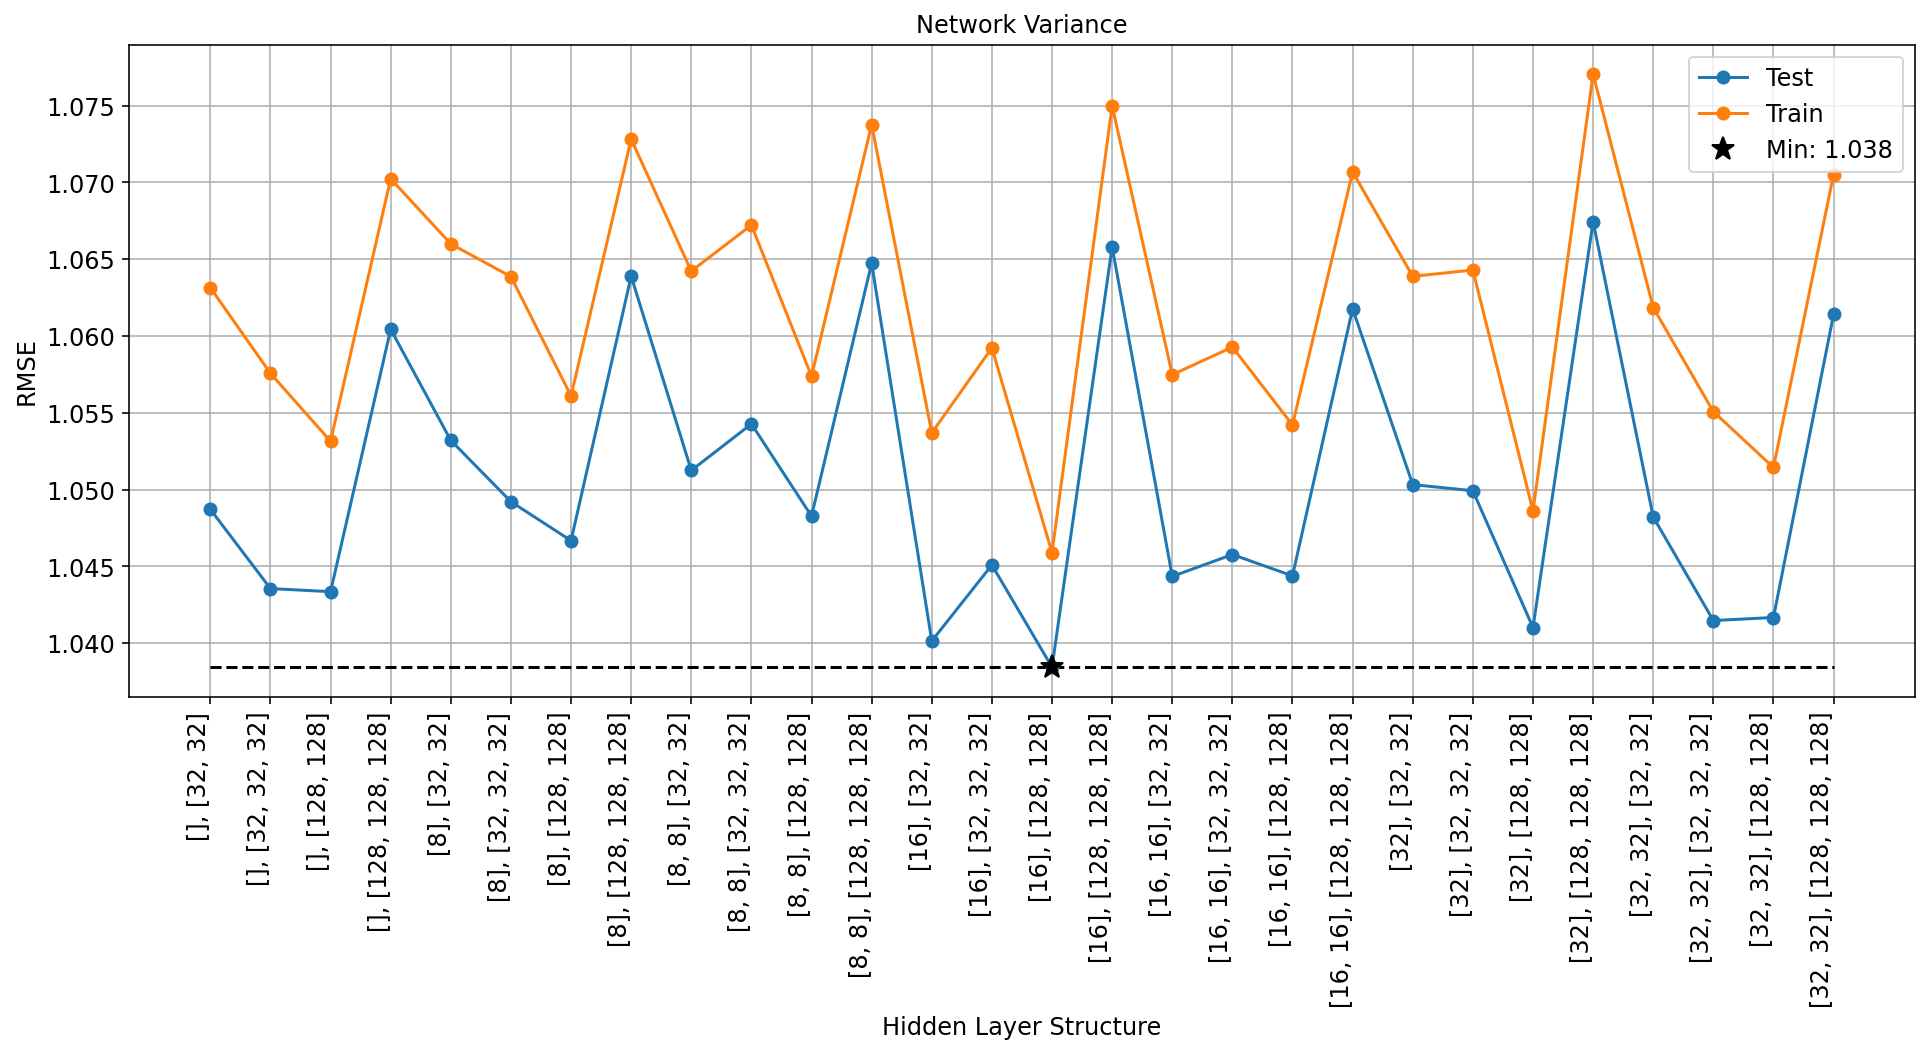

In [57]:
plt.figure(figsize=(16, 6))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(product) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
           rotation=90, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

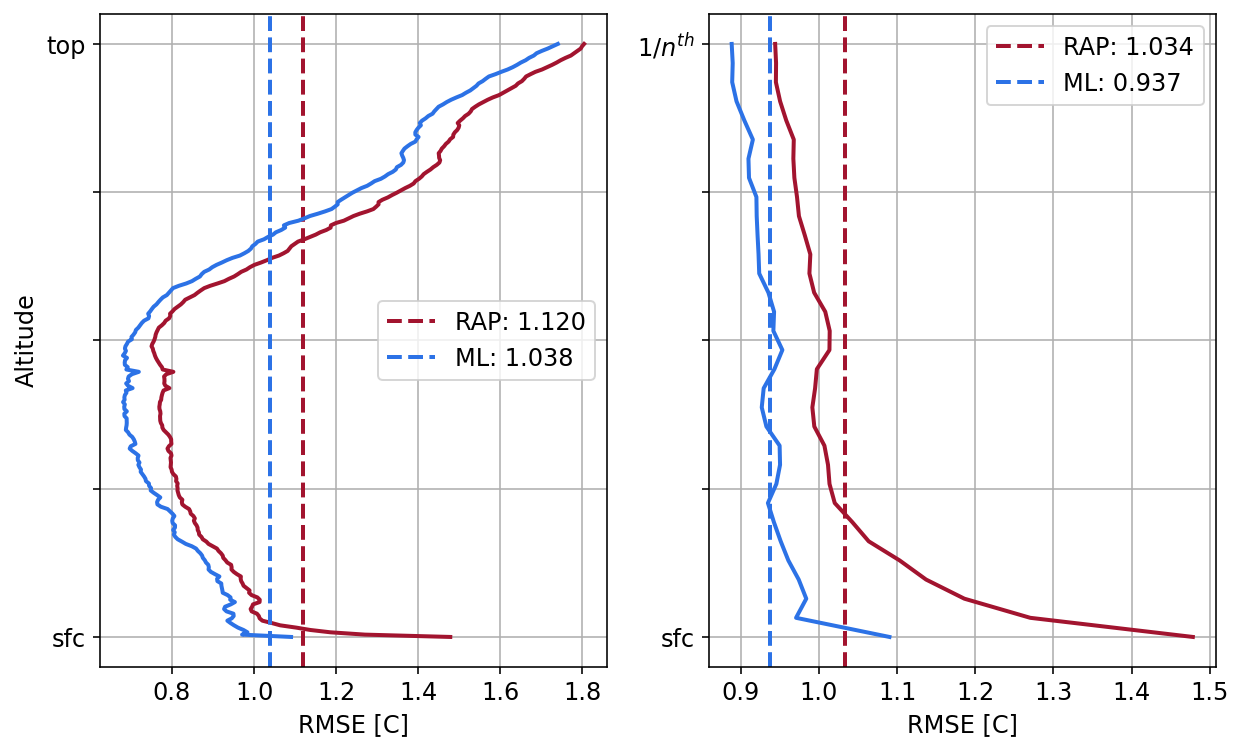

In [58]:
results.plot_altitude_rmse_verticle(best_nnet, {'im': RTMAtest, 'rap': RAPtest}, RAOBtest, RAPtest[:,:,-1], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

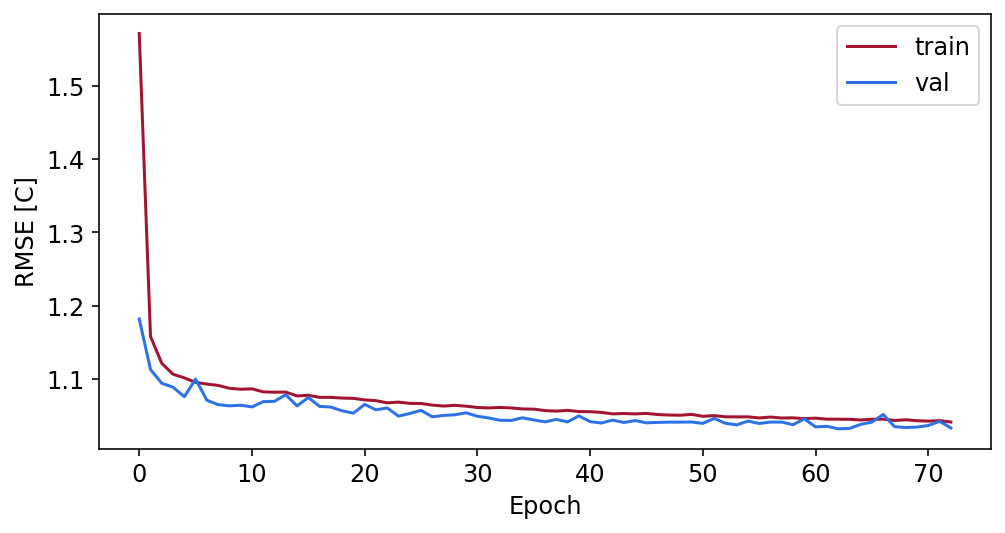

In [59]:
results.plot_loss(best_nnet)

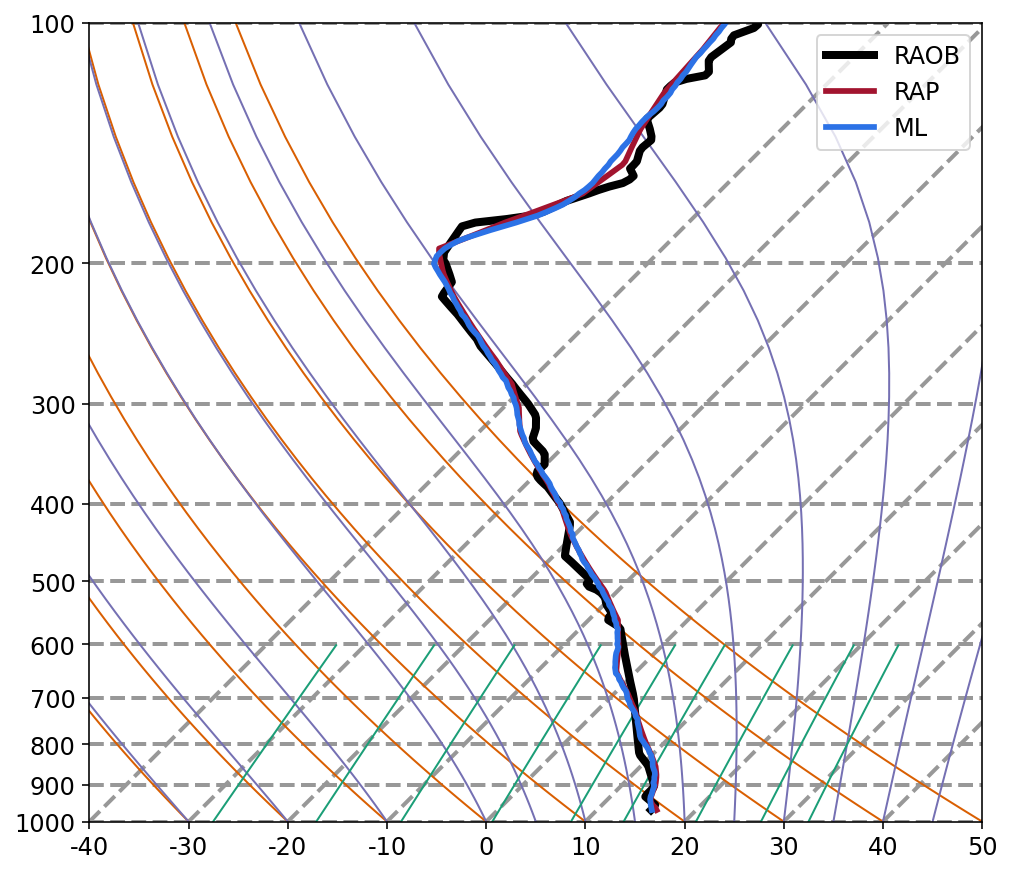

In [60]:
i = 17
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtrain[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtrain[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtrain[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use({'im':RTMAtrain[i:i+1],'rap':RAPtrain[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

In [62]:
best_nnet.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rap (InputLayer)                [(None, 256, 2)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 128)     2688        rap[0][0]                        
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 128, 128)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
im (InputLayer)                 [(None, 3, 3, 3)]    0                                            
_______________________________________________________________________________________

In [9]:
rtma_type_indicies = np.arange(len(rtma_type))
combinations = []
for length in rtma_type_indicies:
    combinations += list(itertools.combinations(rtma_type_indicies, length+1))

In [13]:
all_trials = []
trials = 10

f = FloatProgress(min=0, max=len(combinations) * trials)
display(f)

for c in combinations:

    IMtrain = RTMAtrain[:,:,:, c]
    IMtest = RTMAtest[:,:,:, c]

    trial = []

    for t in range(trials):
        nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                                    [16], [128, 128], [(10, 1)]*2, 
                                    RAOBtrain.shape[1], im_activation='tanh',
                                    rap_activation='tanh')

        nnet.train(IMtrain, RAPtrain, RAOBtrain, 100, 64, method='adam',
                   validation=(IMtest, RAPtest, RAOBtest), verbose=False, learning_rate=0.0001)

        Y = nnet.use({'im': IMtest, 'rap': RAPtest})
        rmse = ml.rmse(Y, RAOBtest)

        trial.append(rmse)
        f.value += 1
        
    all_trials.append(trial)
    
all_trials = np.asarray(all_trials)

FloatProgress(value=0.0, max=70.0)

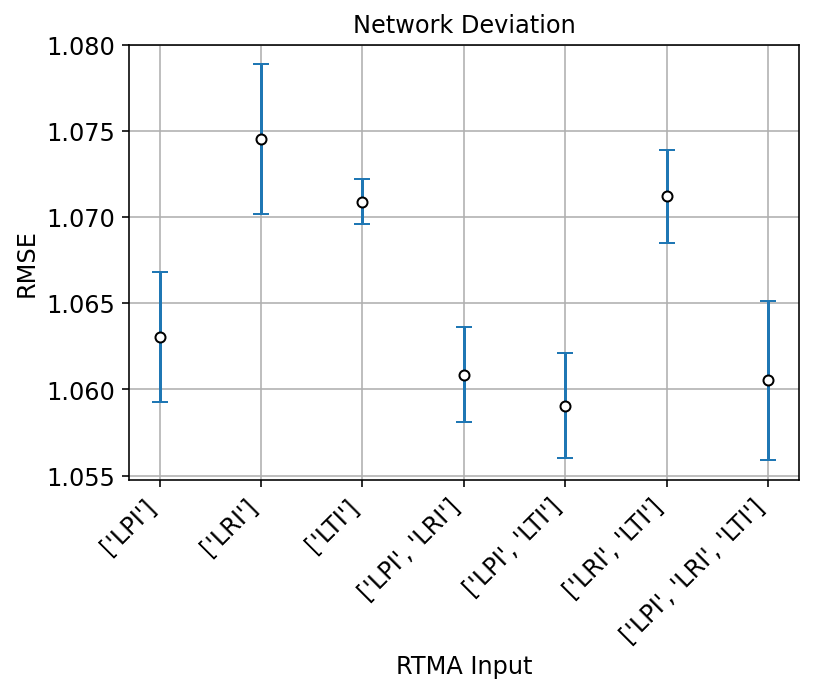

In [14]:
labels = [rtma_type[list(c)].tolist() for c in combinations]


fig, ax = plt.subplots(1, figsize=(6, 4))

ax.errorbar(np.arange(len(combinations)), all_trials.mean(axis=1), yerr=all_trials.std(axis=1),
             linestyle='None', marker='o', capsize=4, markersize=5,
             markeredgecolor='k', markerfacecolor='w')

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')

ax.grid(True); ax.set_title('Network Deviation')
ax.set_xlabel('RTMA Input'); ax.set_ylabel('RMSE');

In [8]:
rtma_type

array(['LPI', 'LRI', 'LTI'], dtype='<U3')

In [17]:
IMtrain = RTMAtrain[:,:,:, [0, 2]]
IMtest = RTMAtest[:,:,:, [0, 2]]

nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                             [16], [128, 128], [(10, 1)]*2, 
                             RAOBtrain.shape[1], im_activation='tanh',
                             rap_activation='tanh')

nnet.train(IMtrain, RAPtrain, RAOBtrain, 100, 64, method='adam',
           validation=(IMtest, RAPtest, RAOBtest), verbose=True, learning_rate=0.0001)

epoch: 0, rmse 1.56336, val_rmse 1.17911
epoch: 20, rmse 1.06720, val_rmse 1.06373
epoch: 40, rmse 1.05203, val_rmse 1.04640


MultiNeuralNetwork(256)
  Final objective value is 0.02874 in 56.6918 seconds.

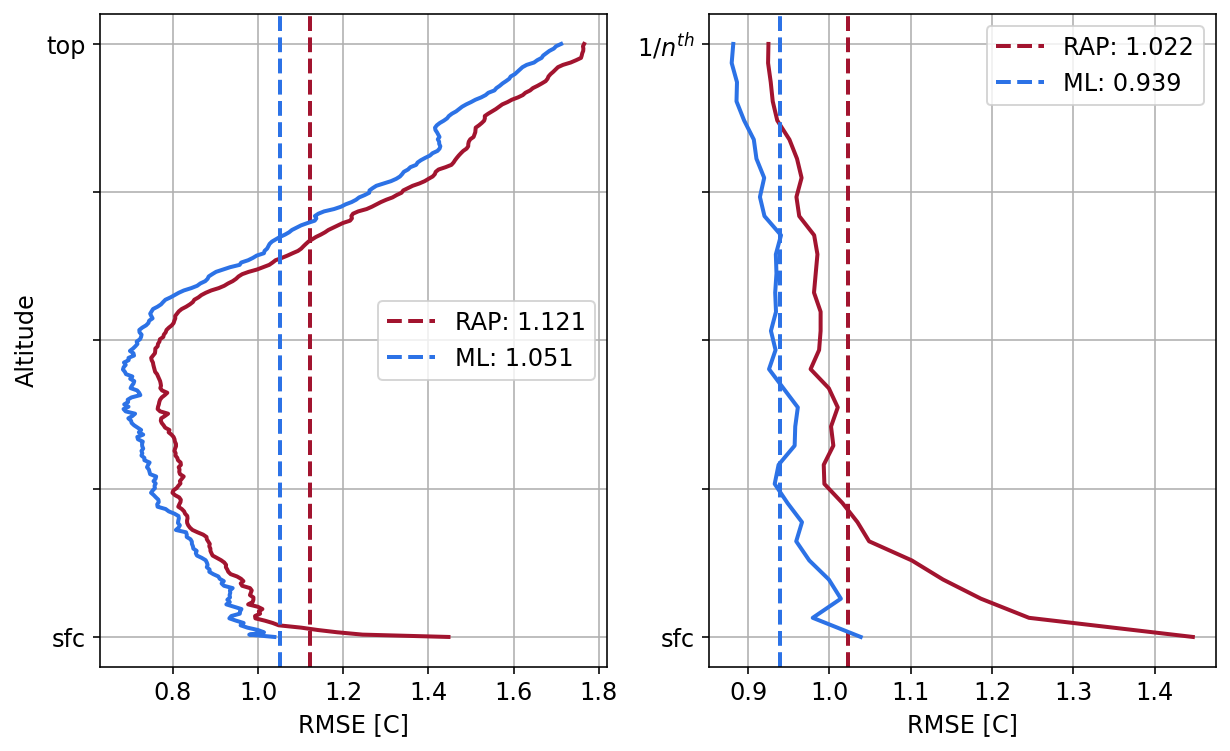

In [18]:
results.plot_altitude_rmse_verticle(nnet, {'im': IMtest, 'rap': RAPtest}, RAOBtest,
                                    RAPtest[:,:,dl.TEMPERATURE], alt=raob[0, :, -1])  

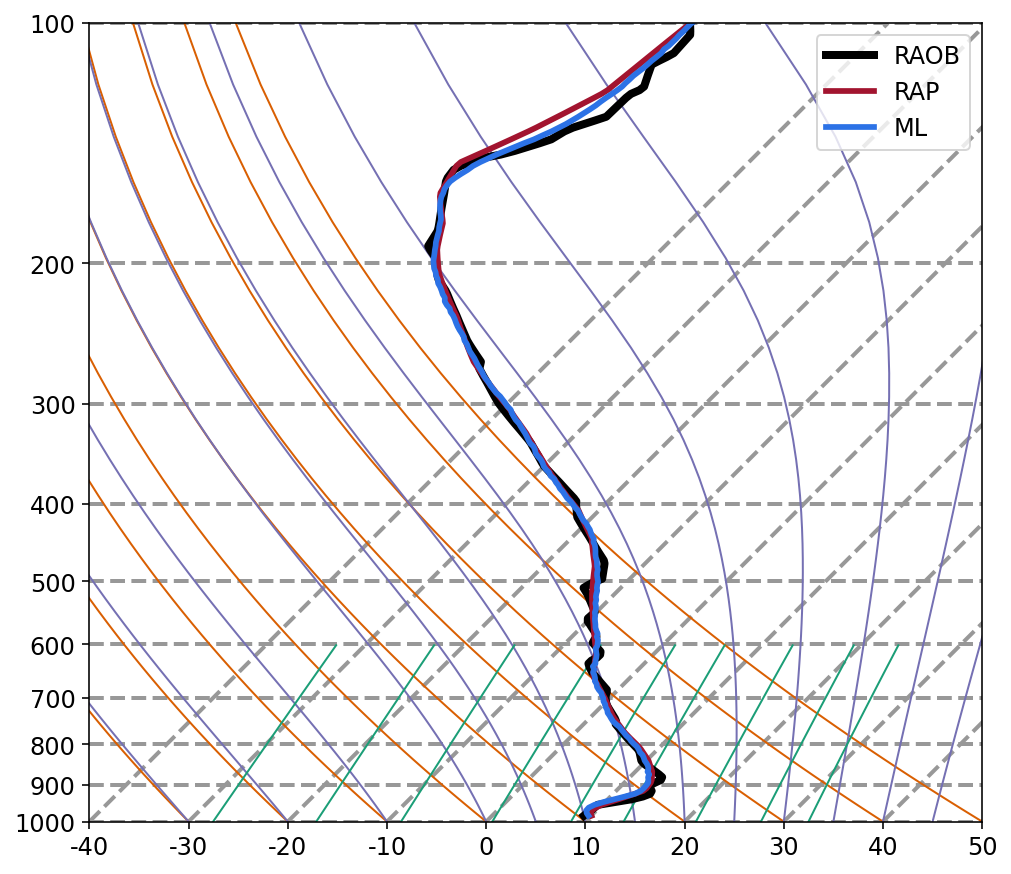

In [19]:
i = 0
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use({'im':IMtest[i:i+1],'rap':RAPtest[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

### Moisture

In [207]:
RAPtrain, RAOBtrain, _, RTMAtrain, RAPtest, RAOBtest, _, RTMAtest = parition(rap=rap, raob=raob, rtma=rtma)

input_dims = [PRESSURE, DEWPOINT]

RAPtrain = RAPtrain[:, :, input_dims]
RAOBtrain = RAOBtrain[:, :, DEWPOINT]

RAPtest = RAPtest[:, :, input_dims]
RAOBtest = RAOBtest[:, :, DEWPOINT]

RAPtrain.shape, RAOBtrain.shape, RTMAtrain.shape, RAPtest.shape, RAOBtest.shape, RTMAtest.shape

((587, 256, 2),
 (587, 256),
 (587, 3, 3, 3),
 (147, 256, 2),
 (147, 256),
 (147, 3, 3, 3))

In [208]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

goes_hiddens_list = [[nu] * nl for nu in [8, 16, 32] for nl in range(1, 4)]
n_units_in_conv_layers = [[nu] * nl for nu in [16, 32, 128] for nl in range(1, 4)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

product = list(itertools.product(goes_hiddens_list, n_units_in_conv_layers))

f = FloatProgress(min=0, max=len(product))
display(f)

for goes_hiddens, n_units_in_conv in product:
    nnet = nn.MultiNeuralNetwork(RTMAtrain.shape[1:], RAPtrain.shape[1:],
                                    goes_hiddens, n_units_in_conv, [(10, 1)]*len(n_units_in_conv), 
                                    RAOBtrain.shape[1], im_activation='tanh', rap_activation='tanh', seed=1234)
    nnet.train(RTMAtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
               verbose=False, learning_rate=0.001)

    Y = nnet.use({'im': RTMAtrain, 'rap': RAPtrain})
    train_percentage.append(ml.rmse(RAOBtrain, Y))

    Y = nnet.use({'im': RTMAtest, 'rap': RAPtest})
    temp = ml.rmse(RAOBtest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

FloatProgress(value=0.0, max=81.0)

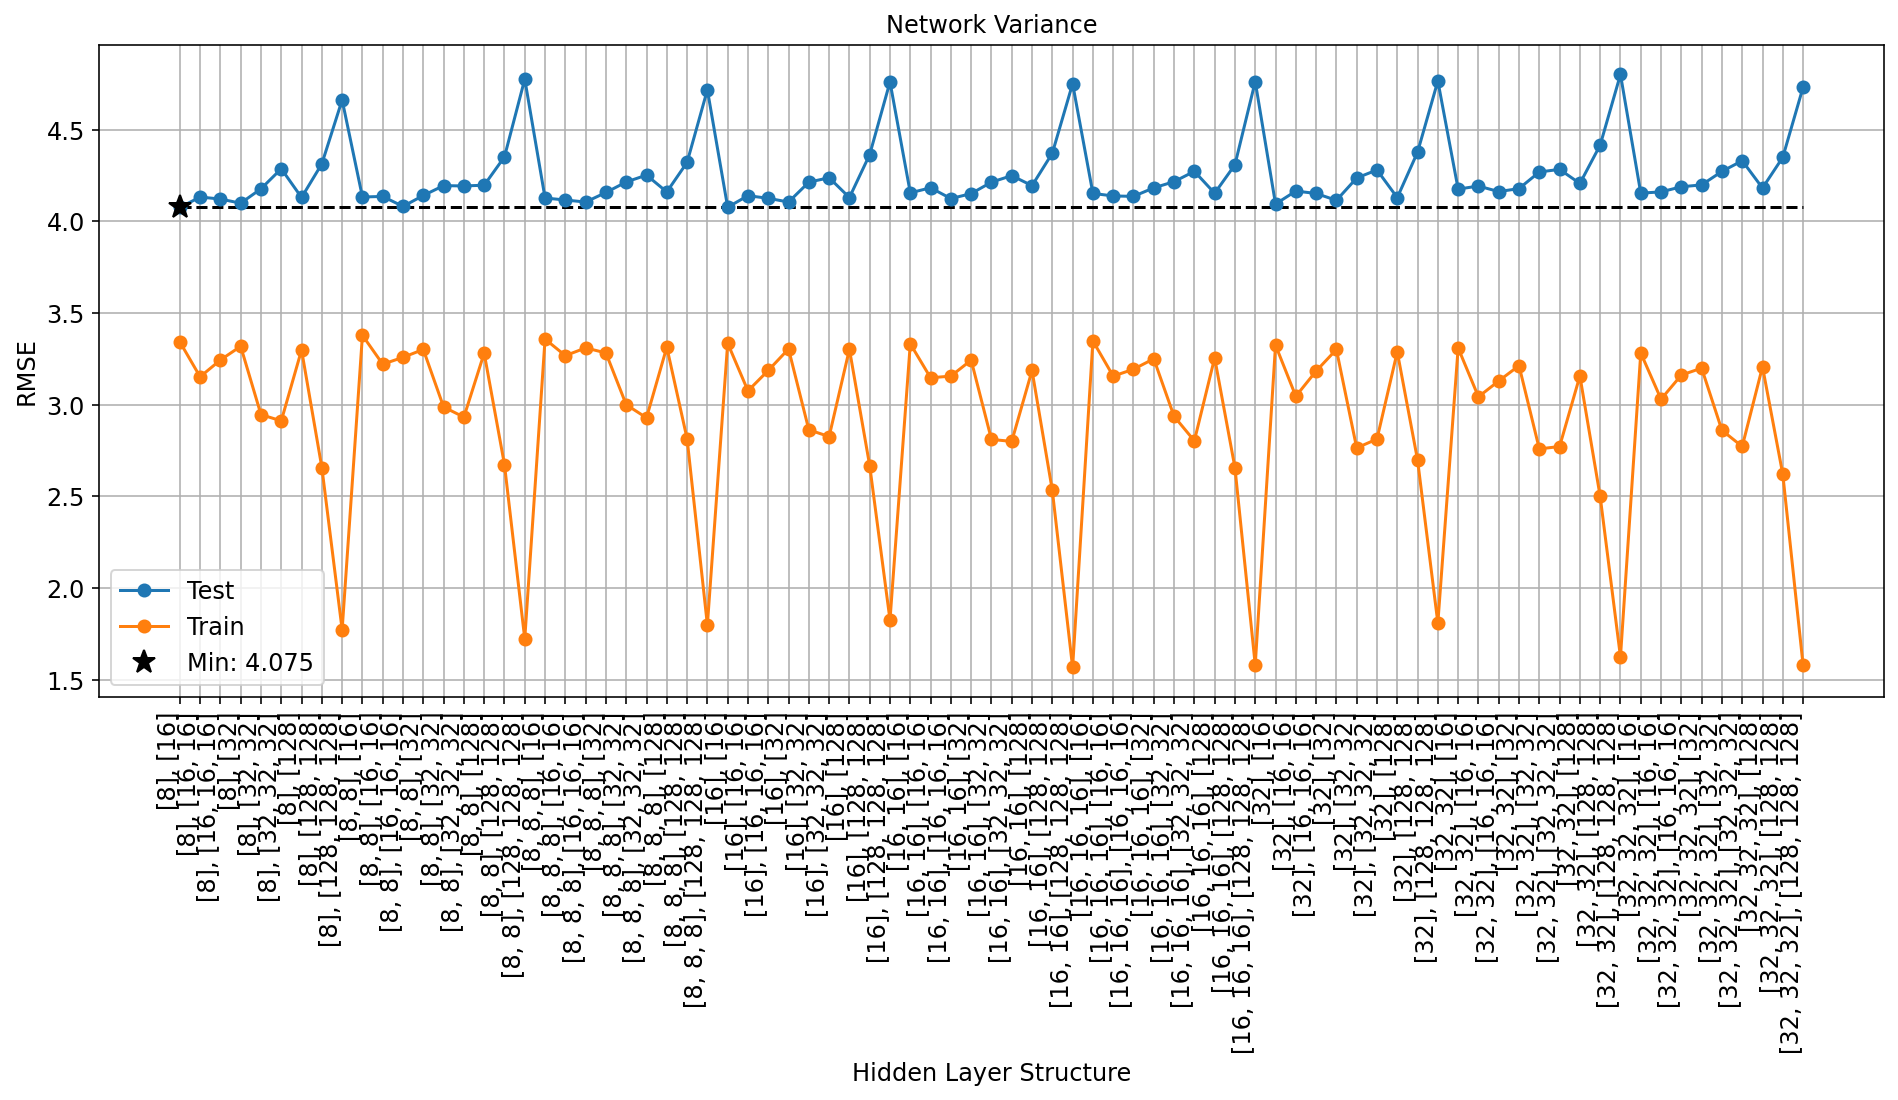

In [209]:
plt.figure(figsize=(16, 6))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(product) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
           rotation=90, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

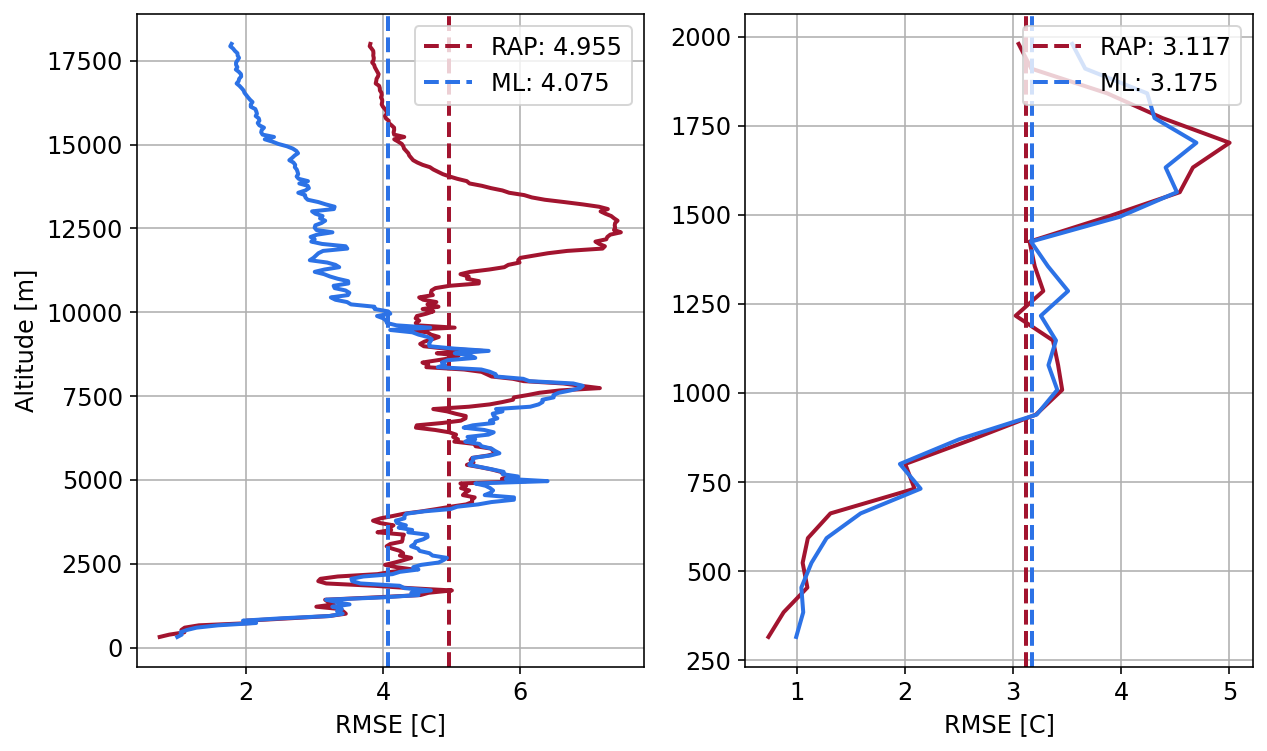

In [210]:
plot_altitude_rmse_verticle(best_nnet, {'im': RTMAtest, 'rap': RAPtest}, RAOBtest, RAPtest[:,:,-1], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

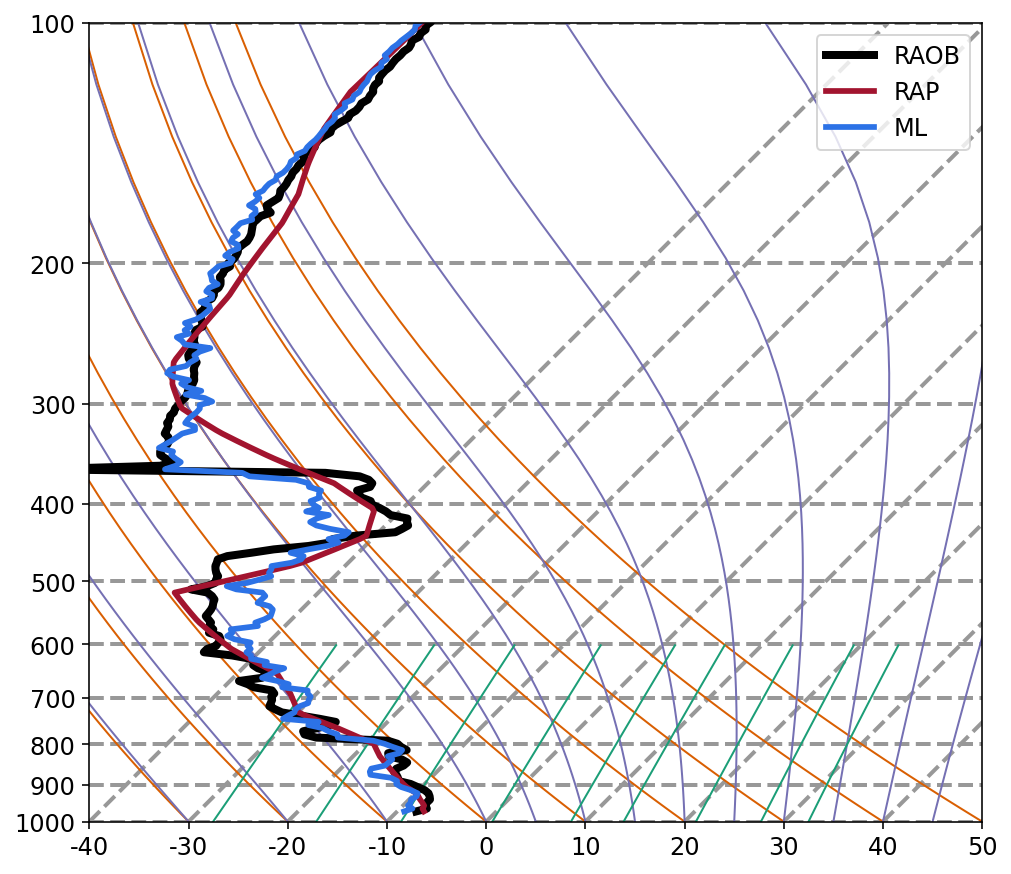

In [213]:
i = 17
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtrain[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtrain[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtrain[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use({'im':RTMAtrain[i:i+1],'rap':RAPtrain[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

In [216]:
rtma_type_indicies = np.arange(len(rtma_type))
combinations = []
for length in rtma_type_indicies:
    combinations += list(itertools.combinations(rtma_type_indicies, length+1))

In [219]:
all_trials = []

for c in combinations:

    IMtrain = RTMAtrain[:,:,:, c]
    IMtest = RTMAtest[:,:,:, c]

    trial = []

    for t in range(10):
        nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                                    [8], [16], [(10, 1)], 
                                    RAOBtrain.shape[1], im_activation='tanh',
                                    rap_activation='tanh')

        nnet.train(IMtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
                   verbose=False, learning_rate=0.001)

        Y = nnet.use({'im': IMtest, 'rap': RAPtest})
        rmse = ml.rmse(Y, RAOBtest)

        trial.append(rmse)
        
    all_trials.append(trial)
    
all_trials = np.asarray(all_trials)

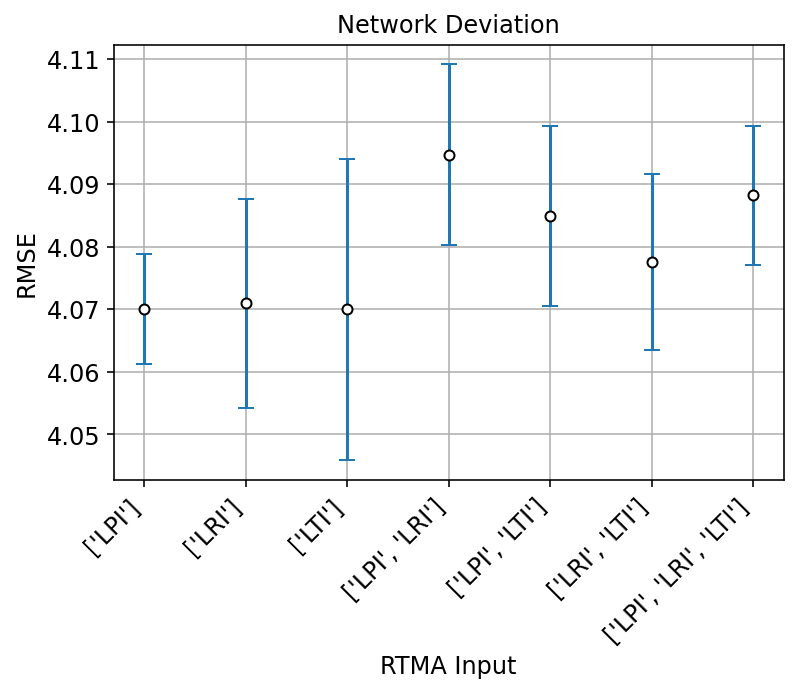

In [220]:
labels = [rtma_type[list(c)].tolist() for c in combinations]

fig, ax = plt.subplots(1, figsize=(6, 4))

ax.errorbar(np.arange(len(combinations)), all_trials.mean(axis=1), yerr=all_trials.std(axis=1),
             linestyle='None', marker='o', capsize=4, markersize=5,
             markeredgecolor='k', markerfacecolor='w')

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')

ax.grid(True); ax.set_title('Network Deviation')
ax.set_xlabel('RTMA Input'); ax.set_ylabel('RMSE');

In [221]:
rtma_type

array(['LPI', 'LRI', 'LTI'], dtype='<U3')

In [222]:
IMtrain = RTMAtrain[:,:,:, (0,)]
IMtest = RTMAtest[:,:,:, (0,)]

nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                             [16], [16], [(10, 1)], 
                             RAOBtrain.shape[1], im_activation='tanh',
                             rap_activation='tanh')

nnet.train(IMtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
           verbose=False, learning_rate=0.001)

MultiNeuralNetwork(256)
  Final objective value is 0.27589 in 2.4585 seconds.

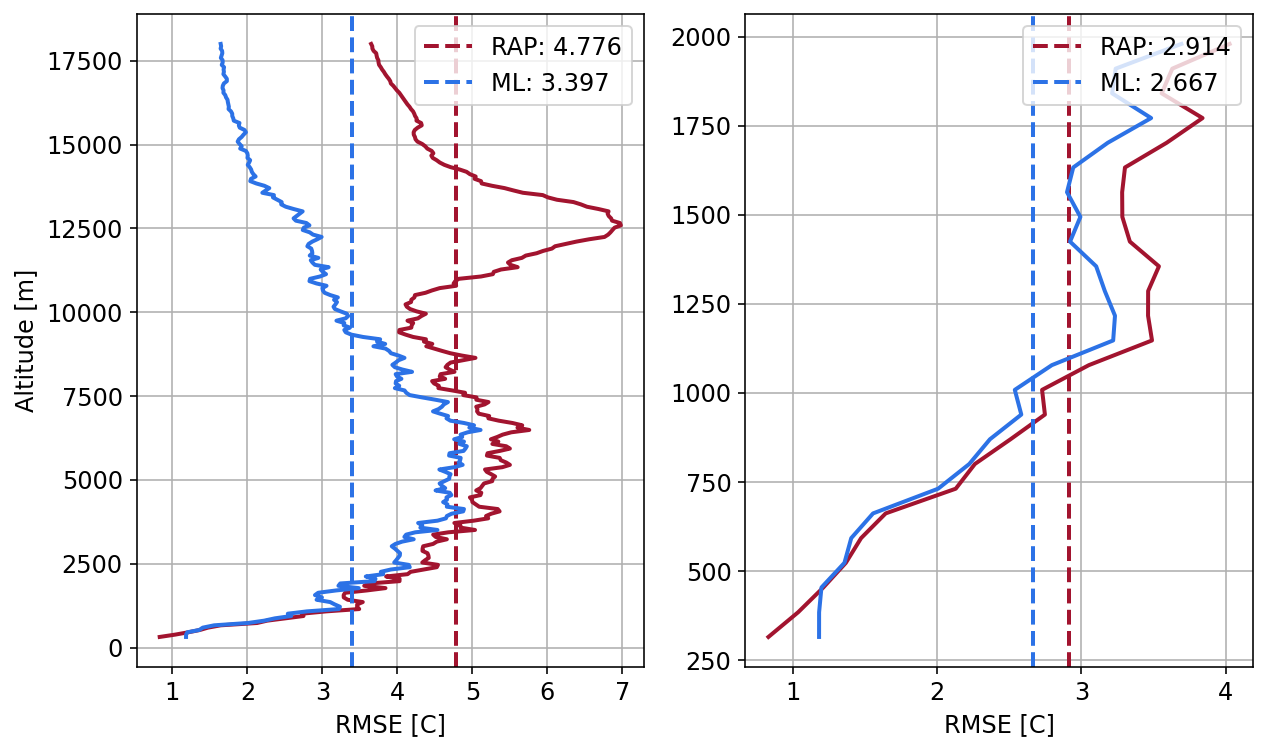

In [223]:
plot_altitude_rmse_verticle(nnet, {'im': IMtrain, 'rap': RAPtrain}, RAOBtrain, RAPtrain[:,:,TEMPERATURE], alt=raob[0, :, -1])  